In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 # Argon Physical Properties
rho = 1.633             #[kg/m^3]  Density
C = 520                 #[J/kg-K]  Specific Heat Capacit
alpha = 2.2e-5          #[m^2/s]   Thermal diffusivity
mu = 3.77e-5            # Dynamic viscosity
nu = mu/rho             # [Pa-s]

#REMOVE THIS LINE!!!!!!###################################
nu = 0.1
#REMOVE THAT LINE!!!!!!################################### 

# Inlet velocity
u_inlet = 4              

#Meshing
Lx = 0.4       #[m]
Ly = 0.4       #[m]
dx = 0.02     #[m]
dy = 0.02     #[m]
dt = 0.0001 
t_max = 2     #[s]    
x = np.arange(0, Lx+dx, dx)
Nx = len(x) - 1
y = np.arange(0, Ly+dy, dy)
Ny = len(y) - 1
t = np.arange(0, t_max+dt, dt)
num_timesteps = int(len(t) - 1)
# Inlet
inlet_height = 0.3
inlet_size = 0.05
outlet_height = 0.15
outlet_size = 0.05



tol = 1e-5

In [3]:
print('Number of points (x-direction): {0:2d} '.format(Nx+1))
print('Number of points (y-direction): {0:2d} '.format(Ny+1))
print('Mesh size (dx): {0:.8f} mm'.format(dx))
print('Mesh size (dy): {0:.8f} mm'.format(dy))
print('Number of time steps: {0:2d} '.format(num_timesteps))
print('Time step (dt): {0:.8f} s'.format(dt))


Number of points (x-direction): 21 
Number of points (y-direction): 21 
Mesh size (dx): 0.02000000 mm
Mesh size (dy): 0.02000000 mm
Number of time steps: 20000 
Time step (dt): 0.00010000 s


In [4]:
u = np.zeros((Nx+2, Ny+2))
v = np.zeros((Nx+2, Ny+2)) # Apply boundary condition on index Nx-1
p = np.zeros((Nx+2, Ny+2))

In [5]:
# Initial Condition

# Left wall
u[0,5:10] = 5


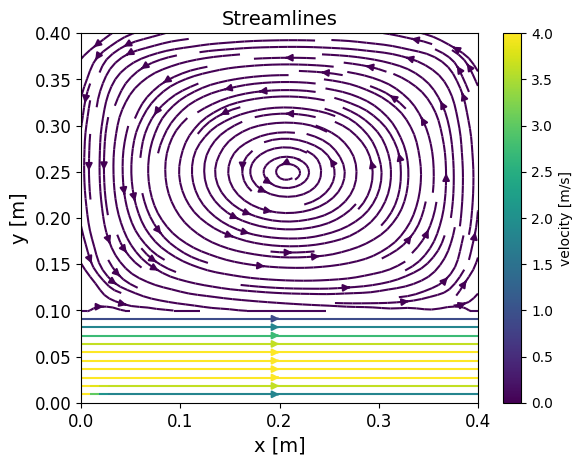

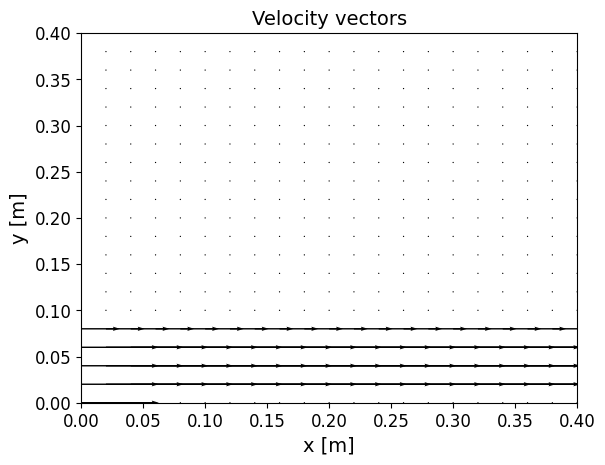

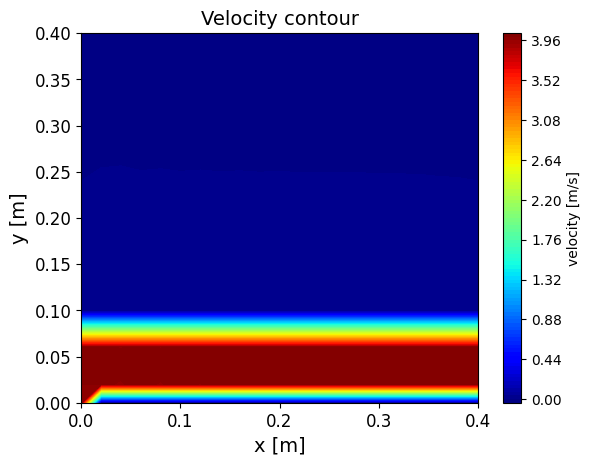

In [6]:
for n in range(25000):
    
    
    # A (Convective term)
    # Structure to understand
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)

    
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    #v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    #u_temp[-2,:10] = 0
    u_temp[-1,:5] = u_temp[-2,:5]
    u_temp[-2,5:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = u_inlet
    u_temp[0,5:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = p.copy()
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-1,:5] = u[-2,:5]
    u[-2,5:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = u_inlet
    u[0,5:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store1 = u
v_store1 = v


In [7]:
for n in range(5000):
    
    # A (Convective term)
    # Structure to understand

    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)

    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 


    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    u_temp[-2,:10] = 0
    u_temp[-1,10:15] = u_temp[-2,10:15]
    u_temp[-2,15:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = 0
    u_temp[0,5:10] = u_inlet
    u_temp[0,10:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = np.zeros_like(p)
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:10] = 0
    u[-1,10:15] = u[-2,10:15]
    u[-2,15:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = 0
    u[0,5:10] = u_inlet
    u[0,10:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store2 = u
v_store2 = v


KeyboardInterrupt: 

In [ ]:
for n in range(5000):
    
    # A (Convective term)
    # Structure to understand

    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    u_temp[-2,:10] = 0
    u_temp[-1,10:15] = u_temp[-2,10:15]
    u_temp[-2,15:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = 0
    u_temp[0,5:10] = u_inlet
    u_temp[0,10:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = np.zeros_like(p)
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:10] = 0
    u[-1,10:15] = u[-2,10:15]
    u[-2,15:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = 0
    u[0,5:10] = u_inlet
    u[0,10:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store3 = u
v_store3 = v


In [ ]:
for n in range(5000):
    
    
    # A (Convective term)
    # Structure to understand

    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    u_temp[-2,:10] = 0
    u_temp[-1,10:15] = u_temp[-2,10:15]
    u_temp[-2,15:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = 0
    u_temp[0,5:10] = u_inlet
    u_temp[0,10:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = np.zeros_like(p)
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:10] = 0
    u[-1,10:15] = u[-2,10:15]
    u[-2,15:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = 0
    u[0,5:10] = u_inlet
    u[0,10:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store4 = u
v_store4 = v


In [ ]:
for n in range(500):
    
    
    # A (Convective term)
    # Structure to understand
    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    u_temp[-2,:10] = 0
    u_temp[-1,10:15] = u_temp[-2,10:15]
    u_temp[-2,15:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = 0
    u_temp[0,5:10] = u_inlet
    u_temp[0,10:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = np.zeros_like(p)
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:10] = 0
    u[-1,10:15] = u[-2,10:15]
    u[-2,15:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = 0
    u[0,5:10] = u_inlet
    u[0,10:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store5 = u
v_store5 = v


In [ ]:
for n in range(5000):
    

    
    # A (Convective term)
    # Structure to understand

    A_u = -((((u[1:-1,1:-1] + u[2:,1:-1])/2)**2 - ((u[1:-1,1:-1] + u[0:-2,1:-1])/2)**2)/dx + (((u[1:-1,2:] + u[1:-1,1:-1])/2)*((v[2:,1:-1] + v[1:-1,1:-1])/2) - ((u[1:-1,1:-1] + u[1:-1,:-2])/2)*((v[1:-1,0:-2] + v[2:,0:-2])/2))/dy)
    A_v = -((((v[1:-1,1:-1] + v[2:,1:-1])/2)*((u[1:-1,1:-1] + u[1:-1,:-2])/2) - ((v[1:-1,1:-1] + v[:-2,1:-1])/2)*((u[0:-2,2:] + u[0:-2,1:-1])/2))/dx + (((v[1:-1,1:-1] + v[1:-1,2:])/2)**2 - ((v[1:-1,1:-1] + v[1:-1,0:-2])/2)**2)/dy)
    """print(np.shape(A_u))
    print(np.shape(A_v))"""
    # B (Diffusion term)
    B_u = nu*((u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1])/dx**2) 
    B_v = nu*((v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,0:-2])/dy**2) 
    """print(np.shape(B_u))
    print(np.shape(B_v))"""

    # Step 1 - Compute u_temp and v_temp (u* in the discretization)
    u_temp = np.zeros_like(u)
    v_temp = np.zeros_like(v)
    u_temp[1:-1, 1:-1] = u[1:-1, 1:-1] + dt*(A_u + B_u)
    v_temp[1:-1, 1:-1] = v[1:-1, 1:-1] + dt*(A_v + B_v)

    # Boundary conditions on u* and v*

    # Bottom wall
    u_temp[:,0] = - u_temp[:,1]
    v_temp[:,0] = 0

    # Top wall
    u_temp[:,-1] = - u_temp[:,-2]
    v_temp[:,-1] = 0
    v_temp[:,-2] = 0

    # Right wall
    u_temp[-2,:10] = 0
    u_temp[-1,10:15] = u_temp[-2,10:15]
    u_temp[-2,15:] = 0
    v_temp[-1,:] = - v_temp[-2,:]

    # Left wall
    u_temp[0,:5] = 0
    u_temp[0,5:10] = u_inlet
    u_temp[0,10:] = 0
    v_temp[0,:] = - v_temp[1,:]

    


    # Step 2 - Poisson iterative solver for p(n+1)
    error = 1
    p[:,-2] = p[:,-1]   
    p[1,:] = p[0,:]     
    p[:,1] = p[:,0]     
    p[-2,:] = p[-1,:]   
    # p[8,1] = 0.005
        



    p_ref = np.zeros_like(p)
    while error > tol: 

        p[1:-1,1:-1] = (p_ref[:-2,1:-1] + p_ref[2:,1:-1] + p_ref[1:-1,:-2] + p_ref[1:-1,2:])/4 - ((dx**2*rho)/(4*dt))*(((u_temp[1:-1,1:-1] - u_temp[:-2,1:-1])/(dx)) + ((v_temp[1:-1,1:-1] - v_temp[1:-1,0:-2])/(dy)))
        # adding boundary conditions
        #p[30:40,-1] = 4    # Outlet condition

        error =  np.linalg.norm(p-p_ref)
        #print(error)

        p_ref = p.copy()

    p[:,0] = p[:,1]   # Bottom wall   
    p[:,-1] = p[:,-2] # Top wall
    p[-1,:] = p[-2,:] # Right wall
    p[0,:] = p[1,:]   # Left wall
    

    # Compute u(n+1) and v(n+1)
    u[1:-1,1:-1] = u_temp[1:-1,1:-1] - (dt/rho)*((p[2:,1:-1] - p[1:-1,1:-1])/(dx))
    v[1:-1,1:-1] = v_temp[1:-1,1:-1] - (dt/rho)*((p[1:-1,2:] - p[1:-1,1:-1])/(dy))

    # Bottom wall
    u[:,0] = - u[:,1]
    v[:,0] = 0

    # Top wall
    u[:,-1] = - u[:,-2]
    v[:,-1] = 0
    v[:,-2] = 0

    """# Right wall
    u[-1,:] = u[-2,:]
    v[-1,:] = v[-2,:]

    # Left wall
    u[0,:] = 5
    v[0,:] = - v[1,:]"""

    # Right wall
    u[-2,:10] = 0
    u[-1,10:15] = u[-2,10:15]
    u[-2,15:] = 0
    v[-1,:] = - v[-2,:]

    # Left wall
    u[0,:5] = 0
    u[0,5:10] = u_inlet
    u[0,10:] = 0
    v[0,:] = - v[1,:]

xx, yy = np.meshgrid(x,y)

u_plot = (u[:-1,1:] + u[:-1,:-1])/2
v_plot = (v[1:,:-1] + v[:-1,:-1])/2

"""u_plot = u
v_plot = v"""
    
plt.streamplot(xx,yy,u_plot.T, v_plot.T, color=np.sqrt(u_plot.T*u_plot.T + v_plot.T*v_plot.T),density=1.5,linewidth=1.5, cmap=plt.cm.viridis)
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Streamlines', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()


plt.quiver(xx, yy, u_plot.T, v_plot.T)

plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity vectors', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()       

plt.contourf(xx, yy, u_plot.T, v_plot.T, levels = 100, cmap = 'jet')
plt.colorbar(label = 'velocity [m/s]')
plt.xlabel('x [m]',fontsize = 14 )
plt.ylabel('y [m]',fontsize = 14 )
plt.title('Velocity contour', fontsize = 14)
plt.tick_params(labelsize=12)
plt.ylim([0,0.4])
plt.xlim([0,0.4])
plt.show()

u_store6 = u
v_store6 = v


In [ ]:
np.savetxt("u_3s_best.txt", u)
np.savetxt("v_3s_best.txt", v)